# Zero-Shot Learning for Record Linkage

## Load database

In [1]:
%load_ext autoreload
%autoreload 2

## Instantiate collection 

In [655]:
import re
import transformers  # old version '4.25.1'
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
from tools.weaving_tools import SMGCollection,NMSCollection, classify_zero_shot, plot_images

In [167]:
collection = NMSCollection(device= 'mps',img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.filter_records()

# Mapping Images to Taxonomies

## Mistakes or enrichments?

In [168]:

checkpoint = 'openai/clip-vit-base-patch32'
model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [186]:
matches = [re.search(r'[A-Z\-\s]+',str(t)) for t in collection.df.taxonomy.unique()]
matches = set([m.group().strip() for m in matches if m])
labels = list({i for i in matches if len(i) > 1})
#candidate_labels.append('OTHER')
print(labels)

['OFFICE EQUIPMENT', 'CIVIL ENGINEERING', 'PHOTOGRAPHY', 'DOMESTIC', 'MINERAL OILS', 'TRANSPORT', 'MEDICINE', 'ROAD TRANSPORT', 'NON-FERROUS METALS', 'GAS', 'INDUSTRIES', 'AUDIO', 'PNEUMATICS', 'MINING', 'TELECOMMUNICATIONS', 'SHIPPING', 'RAIL TRANSPORT', 'COMPUTING', 'PHYSICS', 'SPORT', 'MECHANICAL ENGINEERING', 'CHEMISTRY', 'HEAT ENGINES', 'AERONAUTICS', 'EXPLOSIVES', 'DOMESTIC EQUIPMENT', 'ELECTRICAL AND ELECTRONIC ENGINEERING', 'FERROUS METALS', 'CARTOGRAPHY', 'CIVIL AND MECHANICAL ENGINEERING', 'BT C', 'HYDRAULICS']


In [185]:
# labels = ['OFFICE EQUIPMENT', 'CIVIL ENGINEERING', 'PHOTOGRAPHY', 'DOMESTIC', 'MINERAL OILS', 
#           'TRANSPORT', 'MEDICINE', 'ROAD TRANSPORT', 'NON-FERROUS METALS', 'GAS', 'INDUSTRIES',
#           'AUDIO', 'PNEUMATICS', 'MINING', 'TELECOMMUNICATIONS', 'SHIPPING', 'RAIL TRANSPORT',
#           'COMPUTING', 'PHYSICS', 'SPORT', 'MECHANICAL ENGINEERING', 'CHEMISTRY', 'HEAT ENGINES', 
#           'AERONAUTICS', 'EXPLOSIVES', 'DOMESTIC EQUIPMENT', 'ELECTRICAL AND ELECTRONIC ENGINEERING',
#           'FERROUS METALS', 'CARTOGRAPHY', 'CIVIL AND MECHANICAL ENGINEERING','HYDRAULICS', 'OTHER']

In [171]:
tqdm.pandas()

In [187]:
collection.df['probs_by_label'] = collection.df.img_path.progress_apply(
                                                            classify_zero_shot, 
                                                            labels = labels,
                                                            model = model,
                                                            processor = processor)

  0%|          | 0/4794 [00:00<?, ?it/s]

In [198]:
collection.df['y_true'] =  collection.df.taxonomy.apply(lambda x: re.search(r'[A-Z\-\s]+',str(x)))
collection.df['y_true'] = collection.df.y_true.apply(lambda x: x.group().strip() if x else 'OTHER')

In [189]:
from sklearn.metrics import classification_report

In [199]:
y_true = list(collection.df['y_true'].values)

In [192]:
# y_true =  [l if l in labels else 'OTHER' 
#             for l in y_true]

In [193]:
y_pred = [res[0]['label'] for res in collection.df['probs_by_label']]

In [194]:
collection.df['probs_by_label'][100]

[{'score': 0.6809417, 'label': 'MINERAL OILS'},
 {'score': 0.16435346, 'label': 'FERROUS METALS'},
 {'score': 0.082889006, 'label': 'NON-FERROUS METALS'},
 {'score': 0.028406005, 'label': 'EXPLOSIVES'},
 {'score': 0.012260715, 'label': 'DOMESTIC EQUIPMENT'},
 {'score': 0.008943565, 'label': 'HEAT ENGINES'},
 {'score': 0.008229021, 'label': 'OFFICE EQUIPMENT'},
 {'score': 0.0042247535, 'label': 'CHEMISTRY'},
 {'score': 0.0017561782, 'label': 'MEDICINE'},
 {'score': 0.0016940685, 'label': 'INDUSTRIES'},
 {'score': 0.0011330113, 'label': 'GAS'},
 {'score': 0.00091379083, 'label': 'CIVIL AND MECHANICAL ENGINEERING'},
 {'score': 0.000784814, 'label': 'MINING'},
 {'score': 0.0006037013, 'label': 'AUDIO'},
 {'score': 0.00049216213, 'label': 'AERONAUTICS'},
 {'score': 0.00037351917, 'label': 'SHIPPING'},
 {'score': 0.0003706513, 'label': 'MECHANICAL ENGINEERING'},
 {'score': 0.00023108305, 'label': 'PNEUMATICS'},
 {'score': 0.00021639372, 'label': 'CIVIL ENGINEERING'},
 {'score': 0.0001679404,

In [195]:
print(classification_report(y_pred, y_true))

                                       precision    recall  f1-score   support

                          AERONAUTICS       0.23      0.91      0.37       229
                                AUDIO       0.18      0.56      0.27        70
                                 BT C       0.00      0.00      0.00        17
                          CARTOGRAPHY       0.00      0.00      0.00       169
                            CHEMISTRY       0.00      0.00      0.00         1
     CIVIL AND MECHANICAL ENGINEERING       0.00      0.00      0.00       138
                    CIVIL ENGINEERING       0.03      0.43      0.06         7
                            COMPUTING       0.00      0.00      0.00        39
                             DOMESTIC       0.00      0.00      0.00         0
                   DOMESTIC EQUIPMENT       0.42      0.15      0.22       378
ELECTRICAL AND ELECTRONIC ENGINEERING       0.17      0.39      0.23        83
                           EXPLOSIVES       0.00   

/Users/kasparbeelen/anaconda3/envs/ce/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kasparbeelen/anaconda3/envs/ce/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kasparbeelen/anaconda3/envs/ce/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [218]:
top_n = 3
collection.df[f'recall@{top_n}'] = collection.df.apply(
                lambda x: x.y_true in [e['label'] for e in x.probs_by_label][:top_n], axis=1
                        )

collection.df[f'recall@{top_n}'].mean()

0.41510221109720485

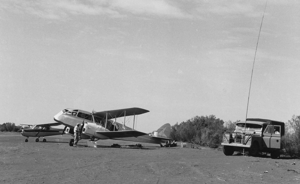

In [240]:
idx = 2010
img = Image.open(collection.df.iloc[idx]['img_path'])
img.thumbnail((300,300))
img

In [241]:
collection.df.iloc[idx][['y_true','probs_by_label']].values

array(['AERONAUTICS',
       list([{'score': 0.51269525, 'label': 'AERONAUTICS'}, {'score': 0.27280867, 'label': 'TRANSPORT'}, {'score': 0.07458231, 'label': 'ROAD TRANSPORT'}, {'score': 0.019748932, 'label': 'HYDRAULICS'}, {'score': 0.016208908, 'label': 'BT C'}, {'score': 0.013685504, 'label': 'MECHANICAL ENGINEERING'}, {'score': 0.013439324, 'label': 'SHIPPING'}, {'score': 0.012643728, 'label': 'CIVIL AND MECHANICAL ENGINEERING'}, {'score': 0.012130376, 'label': 'DOMESTIC EQUIPMENT'}, {'score': 0.0075159348, 'label': 'INDUSTRIES'}, {'score': 0.0071648913, 'label': 'RAIL TRANSPORT'}, {'score': 0.0068766885, 'label': 'OFFICE EQUIPMENT'}, {'score': 0.005624989, 'label': 'TELECOMMUNICATIONS'}, {'score': 0.003413401, 'label': 'SPORT'}, {'score': 0.0025584023, 'label': 'MINING'}, {'score': 0.0024773625, 'label': 'MINERAL OILS'}, {'score': 0.002063638, 'label': 'HEAT ENGINES'}, {'score': 0.0019456543, 'label': 'CARTOGRAPHY'}, {'score': 0.0015631773, 'label': 'AUDIO'}, {'score': 0.001544841

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_pred, y_true)

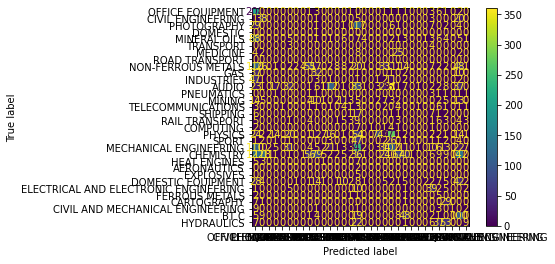

In [216]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels,
                                )
disp.plot()

In [229]:
#collection.df

## Mapping Images to Keyword

In [578]:
from keybert import KeyBERT
kw_model = KeyBERT()
#kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None)

In [579]:
smg = SMGCollection(device= 'mps',img_folder=Path('smg_imgs'))
smg.load_from_csv('data/SMG.csv')
smg.filter_records()

In [580]:
smg.df = smg.df.sample(frac=.1)

In [581]:
smg.df.shape

(4629, 9)

In [582]:
nms = NMSCollection(device= 'mps',img_folder=Path('nms_imgs'))
nms.load_from_csv('data/NMS.csv')
nms.filter_records()

In [785]:
def extract_image_keywords(collection,**kwargs):
    collection.df['description_clean'] = collection.df.description.apply(
                            lambda x: re.sub(re.compile(r'\b1[0-9]{3}\b'),'',x)
                                )
    
    collection.df['keyword'] = collection.df.description_clean.progress_apply(kw_model.extract_keywords,
                                            keyphrase_ngram_range=(1, 3), stop_words='english',
                                            use_maxsum=True, nr_candidates=10, top_n=5)
    
    collection.df['labels'] = collection.df['keyword'].apply(
                            lambda kws: [x[0] for x in kws]
                                )
    
    collection.df['probs_by_label'] = collection.df.progress_apply(
                            lambda x: classify_zero_shot(x.img_path, x.labels , model, processor) if x.labels else {}, 
                                axis=1
                            )
    return True

In [786]:
extract_image_keywords(smg)
extract_image_keywords(nms)

  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/4794 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [787]:
#smg.df

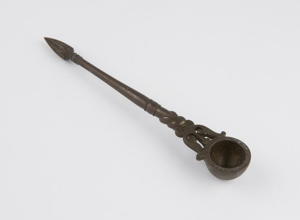

In [788]:
idx = 302
img = Image.open(smg.df.iloc[idx].img_path)
img.thumbnail((300,300))
img

In [789]:
smg.df.iloc[idx]['probs_by_label']

[{'score': 0.983454704284668, 'label': 'lustration spoon brass'},
 {'score': 0.01584046520292759, 'label': 'spoon'},
 {'score': 0.00039848036249168217, 'label': 'brass'},
 {'score': 0.00016098402556963265, 'label': 'indian'},
 {'score': 0.00014534045476466417, 'label': 'lustration'}]

In [790]:
filter_labels = lambda x: [e['label'] for e in x if e['score'] > .1]
smg.df['top_labs'] = smg.df.probs_by_label.apply(filter_labels) 

In [791]:
nms.df['top_labs'] = nms.df.probs_by_label.apply(filter_labels) 

In [792]:
nms.df['top_labs']

0       [pony trap, varnished wood wheels, varnished w...
1                                  [power hydraulic lift]
2                 [long cart, cart used, light long cart]
3            [german silver spoon, silver spoon finished]
4                                           [silver fork]
                              ...                        
4789                     [surveyor dial fitted, surveyor]
4790    [surveyor, surveyor dial fitted, half nineteen...
4791     [surveyor, hedley pattern, surveyor dial fitted]
4792                                    [dial fitted box]
4793                                    [dial fitted box]
Name: top_labs, Length: 4794, dtype: object

In [793]:
from collections import Counter
smg.df['base_url'] = 'https://coimages.sciencemuseumgroup.org.uk/images/'
nms.df['base_url'] = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
smg.df['img_url'] = smg.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)
nms.df['img_url'] = nms.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)
main_df = pd.concat([smg.df,nms.df], axis=0)
all_labels = [l for i, row in main_df.iterrows() for l in row.top_labs]
all_labels = Counter(all_labels)
all_labels =[k for k,v in all_labels.items() if v > 3]
print(len(all_labels))

503


In [794]:
def unique_substrings(substring, string_list):
    """
    Check if a substring appears in a list of strings.

    :param substring: The substring to search for.
    :param string_list: A list of strings to search in.
    :return: True if the substring is found in any of the strings, False otherwise.
    """
    for string in string_list:
        if substring in string:
            return False
    return True

In [795]:
main_df['top_labs']

30485                                                   []
33941              [forceps bronze broken, forceps bronze]
14233                                       [black barbie]
32804                                 [intercom telephone]
24979                                  [votive right foot]
                               ...                        
4789                      [surveyor dial fitted, surveyor]
4790     [surveyor, surveyor dial fitted, half nineteen...
4791      [surveyor, hedley pattern, surveyor dial fitted]
4792                                     [dial fitted box]
4793                                     [dial fitted box]
Name: top_labs, Length: 9423, dtype: object

In [796]:
#main_df['top_labs'] = 
main_df['top_labs'].apply(lambda x:[ l for l in x if check_duplicate_substrings(l, x)])

30485                                                   []
33941              [forceps bronze broken, forceps bronze]
14233                                       [black barbie]
32804                                 [intercom telephone]
24979                                  [votive right foot]
                               ...                        
4789                      [surveyor dial fitted, surveyor]
4790     [surveyor, surveyor dial fitted, half nineteen...
4791      [surveyor, hedley pattern, surveyor dial fitted]
4792                                     [dial fitted box]
4793                                     [dial fitted box]
Name: top_labs, Length: 9423, dtype: object

In [797]:
keyword2img_url = defaultdict(str)
for i, row in main_df.iterrows():
    for l in row.top_labs:
        keyword2img_url[l] = row.img_url

In [798]:
from pyvis.network import Network
#net = Network(notebook=True)
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              notebook=True)



In [799]:
for i, l in enumerate(all_labels):
    if not isinstance(keyword2img_url[l], float):
        net.add_node(i, shape='image', image = keyword2img_url[l], brokenImage='https://www.w3schools.com/w3css/img_lights.jpg')

In [800]:
len(net.nodes)

503

In [801]:
keyword2node_id = {l: i for i,l in enumerate(all_labels)}
for i, row in main_df.iterrows():
    labs = [l for l in set(row.top_labs) if l in all_labels]
    edges = combinations(labs,2)
    for s,t in edges:
        net.add_edge(keyword2node_id[s], keyword2node_id[t], label=f'{s}_{t}')

In [802]:
len(net.edges)

403

In [803]:
net.show("image_network_2.html")

image_network_2.html


In [ ]:
nodeid2imgurl = {i: img_url for i,img_url in enumerate(nodes)}
for k,v in list(nodeid2imgurl.items()):
    if not isinstance(v,float): # check later
        net.add_node(k, shape='image', image = v, brokenImage='https://www.w3schools.com/w3css/img_lights.jpg')
imgurl2nodeid = {j:i for i,j in nodeid2imgurl.items()}

In [ ]:
nodes = [i for i,l in enumerate(all_labels)]

In [727]:
all_labels =  set()
all_labels.update(*list(nms.df.top_labs.values))
print(len(all_labels))
all_labels.update(*list(smg.df.top_labs.values))
print(len(all_labels))

4879
10169


In [591]:
nms_labs = set()
nms_labs.update(*list(nms.df.top_labs.values))

In [592]:
smg_labs = set()
smg_labs.update(*list(smg.df.top_labs.values))

In [593]:
overlapping_labels = smg_labs.intersection(nms_labs)
overlapping_labels

{'18th century',
 '19th century',
 '20th century',
 'abc telegraph',
 'aeroplane',
 'aid kit',
 'air 2000',
 'aluminium',
 'ammeter',
 'antimony',
 'apparatus',
 'atlas lighting',
 'automatic telegraph',
 'badge',
 'bakelite',
 'ball',
 'bandage',
 'bell',
 'bicycle',
 'black',
 'blade',
 'block instrument',
 'board',
 'boiler',
 'bolt',
 'book',
 'bottle',
 'bottle green',
 'bowl',
 'box',
 'brass',
 'brass case',
 'bricks',
 'british railways',
 'british telecom',
 'bronze',
 'brooch',
 'cabinet',
 'cable',
 'cable standard',
 'calculator',
 'calendar',
 'camera',
 'canvas bag',
 'cap',
 'carbonate',
 'card',
 'cardboard box',
 'carrying case',
 'cart model',
 'case',
 'cast',
 'ceramic',
 'certificate',
 'chisel',
 'chromium alloy',
 'cinder',
 'circular',
 'clock',
 'coal',
 'collection',
 'colliery',
 'colour photographs',
 'compact',
 'compass',
 'control unit',
 'controls',
 'copper',
 'copper pyrites',
 'copper slag',
 'copper wire',
 'copper works',
 'cover',
 'covered case',


In [594]:

smg_keyword2img_path = defaultdict(list)
for i, row in smg.df.iterrows():
    for kw in row.top_labs:
        smg_keyword2img_path[kw].append(row.img_path)

In [595]:
nms_keyword2img_path = defaultdict(list)
for i, row in nms.df.iterrows():
    for kw in row.top_labs:
        nms_keyword2img_path[kw].append(row.img_path)

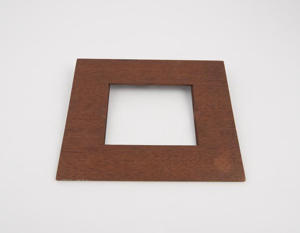

In [596]:
img1 = Image.open(smg_keyword2img_path['mahogany'][0])
img1.thumbnail((300,300))
img1

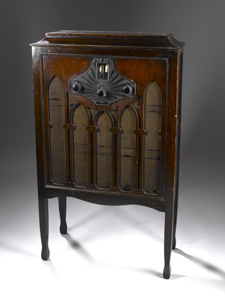

In [597]:
img1 = Image.open(nms_keyword2img_path['mahogany'][0])
img1.thumbnail((300,300))
img1

In [640]:
nodes = set()
keyword2imgurl = defaultdict(set)
keyword2imgpath = defaultdict(set)
for i, row in main_df.iterrows():
    for kw in row.top_labs:
        if kw in overlapping_labels:
            keyword2imgurl[kw].add(row.img_url)
            keyword2imgpath[kw].add(row.img_path)
            nodes.add(row.img_url)

In [882]:
import json
json.dump(list(keyword2imgpath.keys()),open('data/keywords.json','w'))

In [ ]:
smg.load_clip_model()

In [725]:
query_kw = 'microphone'#'paper wrapping'
embeddings = []
for img in keyword2imgpath[query_kw]:
    embeddings.append(smg.clip_model.encode(Image.open(img)))

In [726]:
len(keyword2imgpath[query_kw])

1

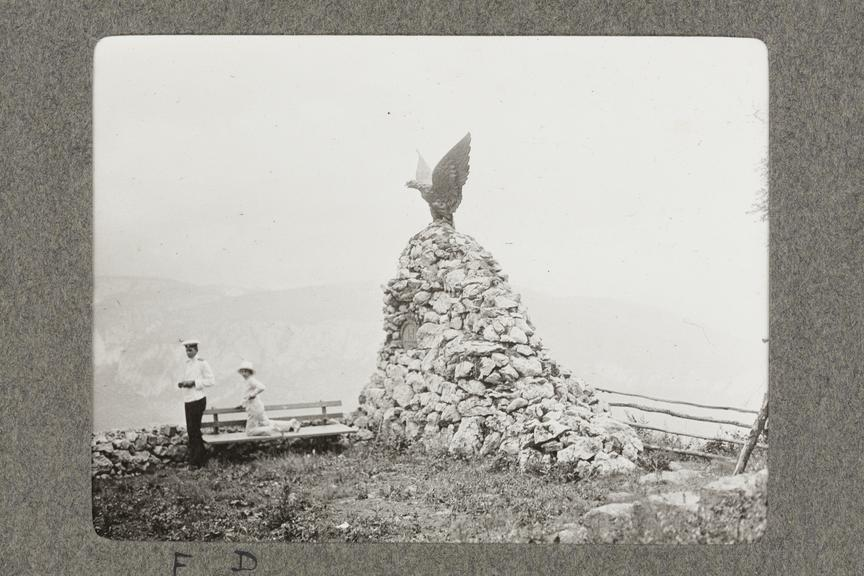

In [724]:
Image.open(list(keyword2imgpath[query_kw])[0])

In [717]:
query_embedding = np.mean(embeddings, axis=0)
query_embedding.shape

(512,)

In [718]:
import chromadb
client = chromadb.PersistentClient(path="ce_vector_db")
db = client.get_or_create_collection(name="congruence_engine")

In [719]:
results = db.query(
    query_embeddings=[list(query_embedding.astype(float))],
    n_results=10,
    #where={"collection": "nms"},
)

In [720]:
query_df = pd.DataFrame(results['metadatas'][0])

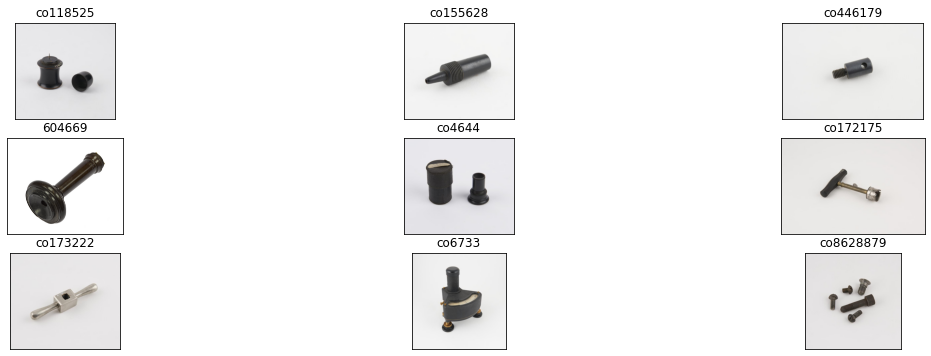

In [721]:
plot_images(query_df)

In [620]:
from pyvis.network import Network
#net = Network(notebook=True)
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              notebook=True)



In [621]:
nodeid2imgurl = {i: img_url for i,img_url in enumerate(nodes)}
for k,v in list(nodeid2imgurl.items()):
    if not isinstance(v,float): # check later
        net.add_node(k, shape='image', image = v, brokenImage='https://www.w3schools.com/w3css/img_lights.jpg')
imgurl2nodeid = {j:i for i,j in nodeid2imgurl.items()}

In [638]:
#net.nodes

In [623]:
from itertools import combinations

In [624]:
for label,nodes in keyword2imgurl.items():
    combs = combinations(nodes, 2)
    for s,t in combs:
        net.add_edge(imgurl2nodeid[s], imgurl2nodeid[t], label=label)

In [639]:
#net.edges

In [627]:
#net.show("image_network.html")

# Nomic Experiment

In [ ]:
from nomic import atlas
import numpy as np

In [ ]:
%%bash
nomic login pyKINnSOXSivweuAXxprY7j8NtVFI88WC7AeE3BnLAmQZ

In [ ]:
nms_clip_embeddigns = np.array(nms.dataset['clip_image_embedding'])
base_url = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['url'] = nms.df.img_loc.apply(lambda x: base_url + x)
nms_data = [{'category': str(row.taxonomy), 'collection':'nms','id': str(i), 'url': row.url}
            for i, row in nms.df.iterrows()]

In [ ]:
smg_clip_embeddigns = np.array(smg.dataset['clip_image_embedding'])
base_url = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['url'] = smg.df.img_loc.apply(lambda x: base_url + x)
smg_data = [{'category': str(row.taxonomy), 'collection':'smg','id': str(i), 'url': row.url}
            for i, row in smg.df.iterrows()]

In [ ]:
embeddings = np.concatenate([nms_clip_embeddigns,smg_clip_embeddigns], axis=0)

In [ ]:
data = nms_data + smg_data

In [ ]:
len(data), len(embeddings)

In [ ]:
project = atlas.map_embeddings(embeddings=embeddings,
                                data=data,
                                id_field='id',
                                name='CE Map',
                                colorable_fields=['category','collection'],
                                reset_project_if_exists=True)

In [ ]:
nms.df['tax_simpl'] = nms.df.taxonomy.apply(lambda x: re.search(r'[A-Z\-\s]+', str(x)))
nms.df['tax_simpl'] = nms.df['tax_simpl'].apply(lambda x: x.group() if x else 'OTHER')

In [ ]:
clip_embeddigns.shape, len(data)

In [ ]:
print(project)

In [ ]:
dir(nms)

In [ ]:
nms.load_clip_model()

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="google/pix2struct-textcaps-base")

In [ ]:

idx = 302
captioner(nms.df.iloc[idx].img_path)

In [ ]:
Image.open(nms.df.iloc[idx].img_path)

In [ ]:
import pandas as pd
from datasets import Dataset, load_dataset
from PIL import Image
import os
df = nms.df.copy()

# Define a function to load images from file paths
def load_image(image_path):
    return Image.open(image_path)

# Apply the image loading function to the DataFrame
df["image"] = df["img_path"]#.apply(load_image)
df.rename({'description':'text'}, axis=1, inplace=True)
# Create a Hugging Face dataset
dataset = Dataset.from_pandas(df[['text','image']])




In [ ]:
dataset

# Network

In [ ]:
ids2ints = {}

for i,r_id in enumerate(list(nms.df.record_id)):
    ids2ints[r_id] = i
    
for i,r_id in enumerate(list(smg.df.record_id)):
    ids2ints[r_id] = nms.df.shape[0] + i   

In [ ]:
nodes = list(ids2ints.values())

In [ ]:
def result_to_edgelist(results,e1):
    df = pd.DataFrame({k: v[0] for k,v in results.items() if k !='embeddings'} )
    df = pd.concat([df,df.metadatas.apply(pd.Series)], axis=1)
    df['distances'] = (1 / (1+ df.distances)) * 100
    return [(e1,
            ids2ints[row.record_id], 
            row.distances
                        ) for i, row in df.iterrows() 
                if e1 != ids2ints[row.record_id]]

In [ ]:
from tqdm.notebook import tqdm
nodes = []
names = []
edges = []

for i in tqdm(range(1000)): #len(nms.dataset)
    
    
    results_smg = collection.query(
            query_embeddings=[list(np.array(nms.dataset[i]['clip_image_embedding']).astype(float))],
            n_results=3,
            where={"collection": "smg"},
                )
    e1 = ids2ints[nms.dataset[i]['record_id']]
    
    edges.extend(result_to_edgelist(results_smg,e1))
    
    
    results_nms = collection.query(
            query_embeddings=[list(np.array(nms.dataset[i]['clip_image_embedding']).astype(float))],
            n_results=3,
            where={"collection": "nms"},
                )
    
    edges.extend(result_to_edgelist(results_nms,e1))

In [ ]:
nodes = []
for i in edges:
    nodes.extend(i[:2])
nodes = list(set(nodes))

In [ ]:
ints2ids = {v : k for k,v in ids2ints.items()}

In [ ]:
label = [str(ints2ids[n]) for n in nodes] 

In [ ]:
from pyvis.network import Network
#net = Network(notebook=True)
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              notebook=True)

net.add_nodes(
    nodes,
    label=label,
    color=["#00bfff" if i < nms.df.shape[0] else "#ffc0cb" for i in nodes],
)

In [ ]:
net.add_edges(edges)

In [ ]:
#net.show("network.html")

In [ ]:
#net.show_buttons(filter_=['physics'])

In [ ]:
net = draw_network(
    nodes, df, minium_weight=0, repulsion=100, spring_length=500, buttons=["physics"]
)
net.show("match_with_buttons.html")

In [ ]:
net.show_buttons()

In [ ]:
# Image to Text

In [3]:
!pip install bitsandbytes sentencepiece accelerate transformers

In [1]:
checkpoint = "HuggingFaceM4/idefics-9b"

In [2]:
import torch
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
)

processor = AutoProcessor.from_pretrained(checkpoint)

model = IdeficsForVisionText2Text.from_pretrained(
    checkpoint,
    quantization_config=quantization_config,
    device_map="auto"
)

ImportError: Using `load_in_8bit=True` requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes `pip install -i https://test.pypi.org/simple/ bitsandbytes` or pip install bitsandbytes` 

In [804]:
from tools.weaving_tools import VACollection

In [823]:
va = VACollection()

In [847]:
req = va.fetch_records('textiles',3)

In [850]:
req['info']['record_count']

98855

In [851]:
req['info']

{'version': '2.0',
 'record_count': 98855,
 'record_count_exact': True,
 'parameters': {},
 'page_size': 15,
 'pages': 665,
 'page': 3,
 'image_count': 174274}

In [852]:
req['records']

[{'systemNumber': 'O174992',
  'accessionNumber': 'E.1408-1988',
  'objectType': 'Design',
  '_currentLocation': {'id': 'THES49658',
   'displayName': 'Prints & Drawings Study Room, level D',
   'type': 'display',
   'site': 'VA',
   'onDisplay': True,
   'detail': {'free': '', 'case': 'MD', 'shelf': '30', 'box': ''}},
  '_primaryTitle': 'Design for textile',
  '_primaryMaker': {'name': 'Hilde Wagner-Ascher', 'association': 'maker'},
  '_primaryImageId': None,
  '_primaryDate': 'ca. 1930',
  '_primaryPlace': 'Vienna',
  '_warningTypes': [],
  '_images': {}},
 {'systemNumber': 'O174991',
  'accessionNumber': 'E.1407-1988',
  'objectType': 'Design',
  '_currentLocation': {'id': 'THES49658',
   'displayName': 'Prints & Drawings Study Room, level D',
   'type': 'display',
   'site': 'VA',
   'onDisplay': True,
   'detail': {'free': '', 'case': 'MD', 'shelf': '30', 'box': ''}},
  '_primaryTitle': 'Design for textile',
  '_primaryMaker': {'name': 'Hilde Wagner-Ascher', 'association': 'maker'

In [ ]:
record_count = object_info["record_count"]

In [878]:
import requests
req = requests.get('https://api.vam.ac.uk/v2/objects/search?q=textile|mining|machine')
object_data = req.json()
object_info = object_data["info"]

In [879]:
object_info

{'version': '2.0',
 'record_count': 106376,
 'record_count_exact': True,
 'parameters': {},
 'page_size': 15,
 'pages': 665,
 'page': 1,
 'image_count': 181924}